#### Upload AutoClass function 

In [1]:
from AutoClass import AutoClassImpute, take_norm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### Upload data (demo dataset can be found in https://github.com/datapplab/AutoClass/tree/master/datasets)

In [3]:
expr = pd.read_csv('C:/Users/hli45/Desktop/simulated_data/Dataset1/counts.csv',index_col=0)
expr_true = pd.read_csv('C:/Users/hli45/Desktop/simulated_data/Dataset1/truecounts.csv',index_col=0)
cellinfo = pd.read_csv('C:/Users/hli45/Desktop/simulated_data/Dataset1/cellinfo.csv',index_col=0)

In [4]:
X = expr.values #Splash generated scRNA-seq data with dropout
X_true = expr_true.values #Splash generated scRNA-seq data without dropout (ground truth)
Y = cellinfo['Group'].values #cell type label
unique_class = np.unique(Y)
celltypes = Y
K = len(unique_class)
ncell,ngene = X.shape[0],X.shape[1]
print('{} genes, {} cells in {} groups'.format(ngene,ncell,K))

938 genes, 500 cells in 6 groups


In [5]:
#library size normalization followed by a log2 transformation with pseudo count 1
X_norm = take_norm(X)
X_true_norm = take_norm(X_true)

([], <a list of 0 Text yticklabel objects>)

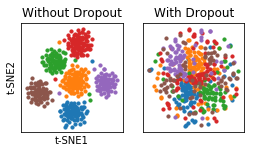

In [6]:
pca_raw = PCA(n_components=50,random_state=1).fit_transform(X_norm)
tsne_raw = TSNE(n_components=2,random_state=1).fit_transform(pca_raw)
pca_true = PCA(n_components=50,random_state=1).fit_transform(X_true_norm)
tsne_true = TSNE(n_components=2,random_state=1).fit_transform(pca_true)

fig = plt.figure(figsize=(4,2))
fig.add_subplot(121)
for i in range(K):
    plt.scatter(tsne_true[Y==unique_class[i],0],
                tsne_true[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Without Dropout')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
    
fig.add_subplot(122)
for i in range(K):
    plt.scatter(tsne_raw[Y==unique_class[i],0],
                tsne_raw[Y==unique_class[i],1], 
                s=10,label = unique_class[i] )
plt.title('With Dropout')
plt.xticks([],[])
plt.yticks([],[])

#### Imputation by AutoClass with default setting

In [7]:
res = AutoClassImpute(X)

500 cells and 938 genes
number of clusters in pre-clustering:[8, 9, 10]
n_cluster = 8...
n_cluster = 9...
n_cluster = 10...
escape time is: 22.06964635848999


##### Visualize the imputed result 

Text(0, 0.5, 't-SNE2')

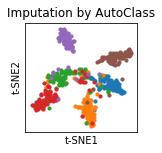

In [8]:
imp = res['imp'] ##imputation result (already normalized, ready for analysis)
PCA_imp = PCA(n_components=50).fit_transform(imp)
tsne_imp = TSNE(n_components=2).fit_transform(PCA_imp)
fig = plt.figure(figsize=(2,2))
for i in range(K):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

##### Print model information

In [9]:
print(res['model'][0].summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 938)]        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 938)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          120192      dropout[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

### Imputation by AutoClass with other parameter settings

- By default, `AutoClassImpute` takes in an unnormalized count matrix and performs library size normalization and log transformation. If your data is already normalized or normalization is not needed, you can set `cellwise_norm=False`, `log1p=False`. E.g.,

  `res = AutoClassImpute(X_norm,cellwise_norm=False,log1p=False)`


- AutoClass use K-means in the pre-clustering step to obtain virtual cluster labels, the default cluster numbers are 8,9,10. Other numbers can be used by setting `num_cluster=[n1,n2,...]`. E.g.,

 `res = AutoClassImpute(X,num_cluster = [5,6,7])`


500 cells and 938 genes
number of clusters in pre-clustering:[5, 6, 7]
n_cluster = 5...
n_cluster = 6...
n_cluster = 7...
escape time is: 25.400148391723633


Text(0, 0.5, 't-SNE2')

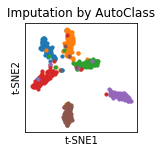

In [10]:
res = AutoClassImpute(X,num_cluster = [5,6,7])
imp_auto = res['imp']
 
PCA_imp = PCA(n_components=50).fit_transform(imp_auto)
tsne_imp = TSNE(n_components=2).fit_transform(PCA_imp)
fig = plt.figure(figsize=(2,2))
for i in range(K):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

- AutoClass loss is a weighted sum of classification loss and reconstruction loss. The weights of these two losses are w and 1-w. Default w is 0.9. Users can change the value of `classifier_weight` to change the classification loss weight. To remove the classifier component, set `classifier_weight=0`. I.e.,
  
  `res = AutoClassImpute(X,classifier_weight=0) `


500 cells and 938 genes
no classifier layer
run the model 3 times and average the final imputation results
n_run = 1...
n_run = 2...
n_run = 3...
escape time is: 43.65102815628052


Text(0, 0.5, 't-SNE2')

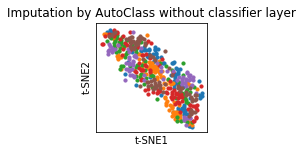

In [11]:
res = AutoClassImpute(X,classifier_weight=0)
imp_auto = res['imp']
 
PCA_imp = PCA(n_components=50).fit_transform(imp_auto)
tsne_imp = TSNE(n_components=2).fit_transform(PCA_imp)
fig = plt.figure(figsize=(2,2))
for i in range(K):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass without classifier layer')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

- If cell type informatin is provided, it can be used in the AutoClass model directly by passing it to `truelabel` and skip the pre-clustering step. I.e.,

  `res = AutoClassImpute(X,truelabel=celltypes)`

In [12]:
res = AutoClassImpute(X,truelabel=celltypes)
imp_auto = res['imp']

500 cells and 938 genes
use provided celltype information
run the model 3 times and average the final imputation results
n_run = 1...
n_run = 2...
n_run = 3...
escape time is: 31.34990930557251


- By default, dropout of neurons is used to prevent overfitting. Dropout is applied to every layer (except output layers), and dropout weight is 0.1. Users can use other dropout weight by changing the value of `dropout_rate`. E.g.,

  `res = AutoClassImpute(X,dropout_rate=0.3)`


- By default, the autoencoder component in AutoClass contains one hidden layer, i.e., the bottleneck layer, and the default size (number of neurons) is 128. Users can specify other **encoder layer sizes** in `encoder_layer_size`. E.g., autoencoder component with five hidden layers, layer sizes [256,128,32,128,256]:

  `res = AutoClassImpute(X,encoder_layer_size=[256,128,32])`

   Or, autoencoder component with one hidden layer, layer size 16:
   
  `res = AutoClassImpute(X,encoder_layer_size=[16])`


  Tips: if bottleneck layer is too small (e.g., 16), it is better not to use dropout regulerization, and a lower `classifier_weight` value is      recommended.

500 cells and 938 genes
number of clusters in pre-clustering:[8, 9, 10]
n_cluster = 8...
n_cluster = 9...
n_cluster = 10...
escape time is: 13.844875812530518


Text(0, 0.5, 't-SNE2')

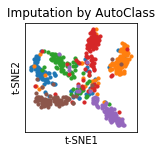

In [13]:
res = AutoClassImpute(X,encoder_layer_size=[16],classifier_weight=0.3,
                      dropout_rate=0)
imp_auto = res['imp']
 
PCA_imp = PCA(n_components=50).fit_transform(imp_auto)
tsne_imp = TSNE(n_components=2).fit_transform(PCA_imp)
fig = plt.figure(figsize=(2,2))
for i in range(K):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')